## 实验项目名称：基于朴素贝叶斯的垃圾短信过滤

## 实验目的和要求：
* 掌握常见的数据读取方式
* 掌握pandas常用属性与方法
* 掌握朴素朴素贝叶斯模型的构建
* 掌握训练集和测试集的划分
* 了解模型评估的方法
* 了解文本分词的方法
* 了解文本可视化的方法


## 实验内容：
#### 首先提取并转化短信中的文本信息，然后用朴素贝叶斯算法对短信进行分类，实现过滤垃圾短信。

贝叶斯模型使用方法参考：https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes

## 实验步骤及结果：

#### 1.数据介绍
该数据集是包含短信的文本信息，带有表明该短信是否为垃圾短信的标签。垃圾短信标记为spam，而非垃圾短信标记为ham。
以下是一些关于垃圾短信和非垃圾短信的例子。

如标记为spam（垃圾短信）：

England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/煤1.20 POBOXox36504W45WQ 16+07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder.

Please call now 08000930705 for delivery tomorrow07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow

标记为ham（非垃圾短信）：

I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.

#### 2.数据读取及数据探索
首先使用 Pandas 库中的read_csv()函数导入sms_spam.csv文件数据。注意读文件编码：encoding='ISO-8859-1'

In [1]:
import pandas as pd
sms_row=pd.read_csv("python_data/sms_spam.csv",encoding="ISO-8859-1")
print(sms_row)

      type                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham              Will Ã¼ b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


使用sms_rowFrame中的descirbe()方法，查看数据情况

In [2]:
sms_row.describe()

,type,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


查看数据大小（即有多少样本，几个特征）

In [3]:
sms_row.shape

(5574, 2)

查看数据类型

In [4]:
sms_row.dtypes

type    object
text    object
dtype: object

当前的特征变量type是一个字符串向量。它是一个分类变量，所以将其转换成一个数值变量将有利于后续的数据处理，用1表示垃圾短信，0表示非垃圾短信

In [5]:
sms_row.astype({'type' : 'str'})
list=[]
for i in sms_row.iloc[:,0]:   
    if i=="ham":list.append(0)
    if i=="spam":i=list.append(1)
new_type=pd.DataFrame(list,columns=['new_type'])
sms_new=pd.concat([sms_row,new_type], axis=1)
sms_new.head()

,type,text,new_type
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


观察特征变量type的分布情况，查看垃圾短信和非垃圾短信分别有多少条

In [6]:
count=sms_new['new_type'].value_counts(1)
print(count*5574)

0    4827.0
1     747.0
Name: new_type, dtype: float64


#### 3 数据准备——处理和分析文本数据
短信就是由词、空格、数字和标点符号组成的文本字符串。处理这种类型的复杂数据需要大量的思考和工作，一方面需要考虑如何去除数字和标点符号，如何处理没有意义的单词，如and、but和or等，以及如何将句子分解成单个的单词。幸运的是，Python 的 sklearn 库中已经包含了这些功能。

处理文本数据的第一步涉及到创建一个语料库，即一个文本文件的集合。在这个例子中，一个文本文件就是指一条短信，通过下面的命令建立一个包含训练数据中短信的语料库。

In [7]:
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

#### 3.1 数据预处理
##### 分割单词
统计一个文件或一个字符串中所有单词出现的次数。由于句子中存在标点符号，直接对字符串切割的话会把单词和标点切割在一起。
语料库现在包含5574条短信的原始文本内容。在将文本内容分解成单词之前，我们需要进行一些清理步骤以去除标点符号和可能会影响结果的其他字符。例如，我们将把单词hello!、HELLO和Hello等都作为单词hello的样本。

首先我们利用translate方法+string.punctuation去除文本内容中的标点符号和数字，并将文本中所有的字符串都转换成小写形式：

In [8]:
def tolower(text):
    return text.lower()

def removePunctuation(text):
    trantab = text.maketrans({key: None for key in string.punctuation+('123456789')})#生成映射表
    return text.translate(trantab)
#处理字符串中的标点符号及数字，如果出现标点和数字就替换为None

sms_new['text']=sms_new['text'].map(removePunctuation).map(tolower)
sms_new

,type,text,new_type
0,ham,go until jurong point crazy available only in ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry in a wkly comp to win fa cup final...,1
3,ham,u dun say so early hor u c already then say,0
4,ham,nah i dont think he goes to usf he lives aroun...,0
...,...,...,...
5569,spam,this is the nd time we have tried contact u u...,1
5570,ham,will ã¼ b going to esplanade fr home,0
5571,ham,pity was in mood for that soany other suggest...,0
5572,ham,the guy did some bitching but i acted like id ...,0


在分析文本数据时，一个常见的做法就是去除填充词，比如to、and、but和or，这些词称为停用词（stop word）。我们将使用sklearn包中的 CountVectorizer 方法来去除停止词并计算文本的词频分布情况。

CountVectorizer是属于常见的特征数值计算类，是一个文本特征提取方法。对于每一个训练文本，它只考虑每种词汇在该训练文本中出现的频率。

CountVectorizer会将文本中的词语转换为词频矩阵，它通过fit_transform函数计算各个词语出现的次数。
stop_words	设置停用词，设为english将使用内置的英语停用词，设为一个list可自定义停用词，设为None不使用停用词，设为None且max_df∈[0.7, 1.0)将自动根据当前的语料库建立停用词表。

decode_error：默认为strict，遇到不能解码的字符将报UnicodeDecodeError错误，设为ignore将会忽略解码错误，还可以设为replace

In [9]:
count_vect = CountVectorizer(stop_words="english",decode_error='ignore')
sms_counts = count_vect.fit_transform(sms_new['text'])
#print(sms_counts)
count_vect.vocabulary_#返回词汇表

{'jurong': 3765,
 'point': 5480,
 'crazy': 1609,
 'available': 553,
 'bugis': 1002,
 'great': 2972,
 'world': 8197,
 'la': 3920,
 'buffet': 1000,
 'cine': 1331,
 'got': 2933,
 'amore': 326,
 'wat': 7962,
 'ok': 5047,
 'lar': 3956,
 'joking': 3733,
 'wif': 8090,
 'oni': 5078,
 'free': 2666,
 'entry': 2263,
 'wkly': 8148,
 'comp': 1445,
 'win': 8104,
 'fa': 2393,
 'cup': 1665,
 'final': 2516,
 'tkts': 7405,
 'st': 6817,
 '00': 0,
 'text': 7244,
 'receive': 5878,
 'questionstd': 5770,
 'txt': 7612,
 'ratetcs': 5823,
 'apply': 407,
 '000overs': 14,
 'dun': 2124,
 'say': 6234,
 'early': 2143,
 'hor': 3307,
 'nah': 4750,
 'dont': 2031,
 'think': 7318,
 'goes': 2889,
 'usf': 7763,
 'lives': 4121,
 'freemsg': 2674,
 'hey': 3204,
 'darling': 1729,
 'weeks': 8019,
 'word': 8183,
 'id': 3426,
 'like': 4071,
 'fun': 2739,
 'tb': 7172,
 'xxx': 8324,
 'std': 6863,
 'chgs': 1276,
 'send': 6325,
 'rcv': 5834,
 'brother': 967,
 'speak': 6732,
 'treat': 7539,
 'aids': 254,
 'patent': 5275,
 'request': 5

由于原始的词频矩阵中维度过高，所以我们考虑利用TF-IDF进行特征提取，设定最小词频数为5，共提取出 1489 个变量。

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words="english",decode_error='ignore',min_df=5)
sms_tfidf = tfidf_vect.fit_transform(sms_new['text'])
print(sms_tfidf)

  (0, 1392)	0.24957440209745532
  (0, 505)	0.20520670087532522
  (0, 220)	0.36977694791468796
  (0, 662)	0.3588431134526403
  (0, 1451)	0.3018497639522368
  (0, 509)	0.24362782863457974
  (0, 157)	0.36977694791468796
  (0, 87)	0.33284280367971714
  (0, 273)	0.3389756857538296
  (0, 958)	0.34235627475788927
  (1, 1421)	0.5150086246115386
  (1, 640)	0.6248349687001974
  (1, 668)	0.4872048371517248
  (1, 882)	0.32707617632765007
  (2, 63)	0.255158847512287
  (2, 1321)	0.19076417867891038
  (2, 1016)	0.25270945096907044
  (2, 1248)	0.18643200729558965
  (2, 0)	0.16570337756281314
  (2, 1181)	0.23786188212796605
  (2, 431)	0.2781402102909373
  (2, 280)	0.30089158501706936
  (2, 1425)	0.22385530616502997
  (2, 241)	0.29726949876804276
  (2, 1435)	0.28798053890167397
  :	:
  (5569, 367)	0.29079411207276706
  (5569, 789)	0.3129803738784916
  (5569, 253)	0.25452360207125974
  (5569, 1275)	0.2047625364922822
  (5569, 1306)	0.30638298855832286
  (5569, 844)	0.287932360273848
  (5569, 1440)	0.2512

#### 3.2 建立训练数据集和测试数据集
由于已经为分析准备好了数据，所以现在我们需要将数据分成训练数据集和测试数据集，从而可以把垃圾短信分类器应用到之前没有学习过的数据上，并据此对分类器的性能进行评估。

In [11]:
from sklearn.model_selection import train_test_split
sms_train_x,sms_test_x,sms_train_y,sms_test_y=train_test_split(sms_tfidf,sms_new['new_type'],test_size=0.2, random_state=None)
print("训练数据集的x大小为 ",sms_train_x.shape)
print("训练数据集的y大小为 ",sms_train_y.shape)
print("测试数据集的x大小为 ",sms_test_x.shape)
print("测试数据集的y大小为 ",sms_train_y.shape)

训练数据集的x大小为  (4459, 1501)
训练数据集的y大小为  (4459,)
测试数据集的x大小为  (1115, 1501)
测试数据集的y大小为  (4459,)


#### 3.3 可视化文本数据——词云
词云是一种可视化地描绘单词出现在文本数据中频率的方式。词云是由随机分布在词云图中的单词构成的，经常出现在文本中的单词会以较大的字体呈现，而不太常见的单词将会以较小的字体呈现。最近，这种类型的图已经变得越来越流行，因为它提供了一种观察社交媒体网站上热门话题的方式。

WordCloud包提供了一个简单的函数来创建这种类型的图形，我们将应用这个函数使短信中单词类型可视化。比较垃圾短信和非垃圾短信的词云将有助于我们了解朴素贝叶斯短信过滤器是否有可能成功

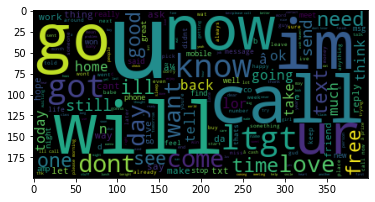

In [12]:
wc = WordCloud()
wc.generate(''.join(sms_new['text']))
plt.imshow(wc)
plt.show()

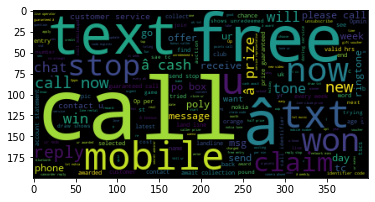

In [13]:
wc.generate(''.join(sms_new['text'][sms_new['new_type']==1]))
plt.imshow(wc)
plt.show()

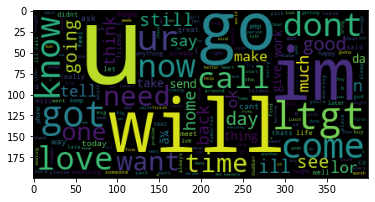

In [14]:
wc.generate(''.join(sms_new['text'][sms_new['new_type']==0]))
plt.imshow(wc)
plt.show()

### 4 训练及测试模型
因为我们已经将原始短信转换成了可以用一个统计模型代表的形式，所以此时是应用朴素贝叶斯算法的时候了。该算法将根据单词的存在与否来统计一条给定的短信是否是垃圾短信的概率。

我们采用sklearn包中的朴素贝叶斯算法实现。

In [15]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB


clf = MultinomialNB()
clf.fit(sms_train_x,sms_train_y)

predicted = pd.DataFrame(clf.predict(sms_test_x),columns=["predict"])
test_row = pd.DataFrame(sms_test_y)
wrong_answer=0
for i in range(0,1115):
    if(predicted.iloc[i,0]!=test_row.iloc[i,0]):
        wrong_answer=wrong_answer+1

print("预测的错误率为 ",wrong_answer/1115)

预测的错误率为  0.023318385650224215


## 实验结果分析:   

1.垃圾短信和非垃圾短信的各有多少？

2.训练集和测试集是如何划分的？

3.在你划分的测试集上，模型评分是多少？

## 实验所需软件环境和库：
Jupyter Notebook、Python、Sklearn、Numpy、Pandas、WordCloud

## 教师评语: